**DHULUO POS TAGGER**

#Import Required Libraries

In [ ]:

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
from tensorflow.keras.utils import to_categorical


import pickle as pk

#Loading dataset
Use pandas to load the data from drive

In [ ]:
# Load Dhuluo POS tagged dataset
# Assuming the dataset has two columns: 'Word' and 'Tag'
df = pd.read_csv("/content/drive/MyDrive/dhuluo_data.csv")

print(df.head(10))
print(df.shape)

      Word   Tag
0     oket     V
1      mar  Conj
2    tieko     V
3     wach    NN
4     tero     V
5    nyiri    NN
6   nyangi    NN
7   ikruok    NN
8     duto   Adj
9  oserumo     V
(54941, 2)


#**DATA PREPOCESSING**




Printing unique classes in the dataset

In [ ]:
unique_classes = df['Tag'].unique()

print("Unique classes in the dataset:")
for cls in unique_classes:
    print(cls)


Unique classes in the dataset:
V
Conj
NN
Adj
Adv
Prep
NUMB
NN+Det
Adj+NN+Adj
Conj+NN
nan
v
Conj+NN+Adj
Det
Adj+V
Adj+Prep
NN+Prep
N
CONJ
PRON
nn
NN+Conj
Conj+V
Det+Prep
ADP
V+Adv
Adv+NN
NN+Adj
ADV
X
NUM
PUNCT
AdJ
 Conj
 NN
DET
ADJ
INTER
 V
  NN
PART
SPEC
V 
ADV 
Ad
NN 
DeT
Conj.
Adj.
x
PUNCt
Det.
AUX
ADP 
conj
Adj 
PUNCT 
NNADP
NNN
VV
PR
aAdj
NU
MM
Adv.
Nn
NU M
INTENS
NUM 
AdV
Adp
AP
ABBR
 PRON
Con
NN  
NUm
XX
 ADP
Adv 
NUMM
DetV
PRONV
 X
Det. 
 Adj
Num
ADv
PROIN
Aj
PUNT
.
PRE
Pron
D
PROn
ADO
Punct
NU 
PUCT
Coinj
ConJ
Aadv
Prep+NN
PRO
Der
Cinj
conj.
CO
punct
adp
CONG
QADP
VADP
COJ
S
C
AD V
Detr
NN /ADJ
Adcv
N N
cv
,
P
Adsv
PU
ADp
x 
NNV
adj
Conj+PRON
V+NN
Adv+V
CONJ.


Checking for null values in the datasets

In [ ]:
df.isnull().sum()

,0
Word,195
Tag,399


In [ ]:
#Check the distribution and statistics
df.describe()

,Word,Tag
count,54746,54542
unique,10748,134
top,.,NN
freq,2617,14006


In [ ]:
class_frequencies = df['Tag'].value_counts()
pd.set_option('display.max_rows', len(class_frequencies))
print("Frequency of each class in the dataset:")
print(class_frequencies)

Frequency of each class in the dataset:
Tag
NN             14006
V              13161
PUNCT           4419
ADP             3799
PRON            2585
Adv             2530
X               2484
Conj            2115
ADV             1415
Adj             1400
Det             1390
CONJ            1385
Conj.           1208
NUM              827
Det.             472
Adj.             367
ADJ              167
PUNCT            110
PUNCt             73
v                 61
ADV               60
Prep              58
DET               54
AdJ               26
NUMB              21
PART              20
INTER             17
PRO               16
x                 16
CONJ.             16
nn                16
N                 14
INTENS            14
Conj+NN           13
DeT               12
V                 10
NN                 7
Adv.               7
Adp                6
NUM                5
XX                 5
ADv                5
AdV                5
conj               4
C                  4
CO         

#Handling Missing Values

In [ ]:
# Drop rows with missing values
df = df.dropna(subset=['Word'])
df = df.dropna(subset=['Tag'])

#Mapping Similar class Tag

In [ ]:
#Convert first to dataframe
df = pd.DataFrame(df)

# Define the mapping dictionary
class_mapping = {
    'NN': 'NN', 'N': 'NN', 'nn': 'NN', 'Nn': 'NN', 'NNN': 'NN', 'N N': 'NN', 'NNV': 'NN', 'NNADP': 'NN', 'NN /ADJ': 'NN',
    'NN+Det': 'NN', 'NN+Prep': 'NN', 'NN+Conj': 'NN', 'NN+Adj': 'NN', 'Adv+NN': 'NN', 'Conj+NN': 'NN', 'Conj+NN+Adj': 'NN',
    'V': 'V', 'v': 'V', 'VV': 'V', 'V+NN': 'V', 'V+Adv': 'V', 'Adj+V': 'V', 'Conj+V': 'V',
    'ADJ': 'ADJ', 'Adj': 'ADJ', 'AdJ': 'ADJ', 'Aj': 'ADJ', 'adj': 'ADJ', 'aAdj': 'ADJ', 'Adj.': 'ADJ', 'Adj+NN+Adj': 'ADJ',
    'ADV': 'ADV', 'Adv': 'ADV', 'AdV': 'ADV', 'ADV ': 'ADV', 'Adv.': 'ADV', 'Ad': 'ADV', 'Aadv': 'ADV', 'Adcv': 'ADV', 'Adsv': 'ADV','ADv':'ADV','AD V':'ADV',
    'ADP': 'ADP', 'Adp': 'ADP', 'adp': 'ADP', 'PREP': 'ADP', 'Prep': 'ADP', 'Prep+NN': 'ADP', 'QADP': 'ADP', 'VADP': 'ADP','ADp':'ADP',
    'PUNCT': 'PUNCT', 'Punct': 'PUNCT', 'PUNCt': 'PUNCT', 'punct': 'PUNCT', 'PUNT': 'PUNCT', 'PUCT': 'PUNCT', 'P': 'PUNCT', ',': 'PUNCT','.':'PUNCT',
    'CONJ': 'CONJ', 'Conj': 'CONJ', 'Conj.': 'CONJ', 'Conj ': 'CONJ', 'conj': 'CONJ', 'conj.': 'CONJ', 'COJ': 'CONJ', 'CONG': 'CONJ', 'CO': 'CONJ', 'Cinj': 'CONJ', 'Coinj': 'CONJ','Con':'CONJ','CONJ.':'CONJ','ConJ':'CONJ',
    'PRON': 'PRON', 'PRO': 'PRON', 'PR': 'PRON', 'PROIN': 'PRON', 'PRONV': 'PRON', 'PROn': 'PRON',
    'DET': 'DET', 'Det': 'DET', 'DeT': 'DET', 'Det.': 'DET', 'Det+Prep': 'DET', 'DetV': 'DET', 'Detr': 'DET',
    'NUM': 'NUM', 'Num': 'NUM', 'NUMB': 'NUM', 'NUMM': 'NUM', 'NU': 'NUM', 'NUm': 'NUM', 'NU M': 'NUM',
    'X': 'X', 'x': 'X', ' XX': 'X','XX':'X',
    'AUX': 'AUX',
    'PART': 'PART',
    'INTENS': 'INTENS',
    'ABBR': 'ABBR',
    'INTER': 'INTER',
    'SPEC': 'SPEC',
    'D': 'D',
    'Der': 'Der',
    'ADO': 'ADO',
    'PU': 'PU'
}

# Function to map class labels
def map_classes(labels, mapping):
    return labels.apply(lambda x: mapping.get(x.strip(), x.strip()))

# Apply the mapping to the DataFrame
df['Mapped_Tag'] = map_classes(df['Tag'], class_mapping)

# Print unique mapped classes and their counts
# unique_mapped_classes = df['Mapped_Tag'].value_counts()
# print("Unique Mapped Classes and Counts:\n", unique_mapped_classes)

# #Unique original classes
# unique_or_classes = df['Tag'].value_counts()
# print("Unique Original Classes and Counts:\n", unique_or_classes)

# Print the DataFrame to see the results
print(df.head(20))

        Word   Tag Mapped_Tag
0       oket     V          V
1        mar  Conj       CONJ
2      tieko     V          V
3       wach    NN         NN
4       tero     V          V
5      nyiri    NN         NN
6     nyangi    NN         NN
7     ikruok    NN         NN
8       duto   Adj        ADJ
9    oserumo     V          V
10    motelo   Adv        ADV
11        ne  Prep        ADP
12  chakruok    NN         NN
13      penj    NN         NN
14   madongo   Adj        ADJ
15       mag   Adj        ADJ
16     class    NN         NN
17         8  NUMB        NUM
18       kod  Conj       CONJ
19        12  NUMB        NUM


#Visualization of the dataset

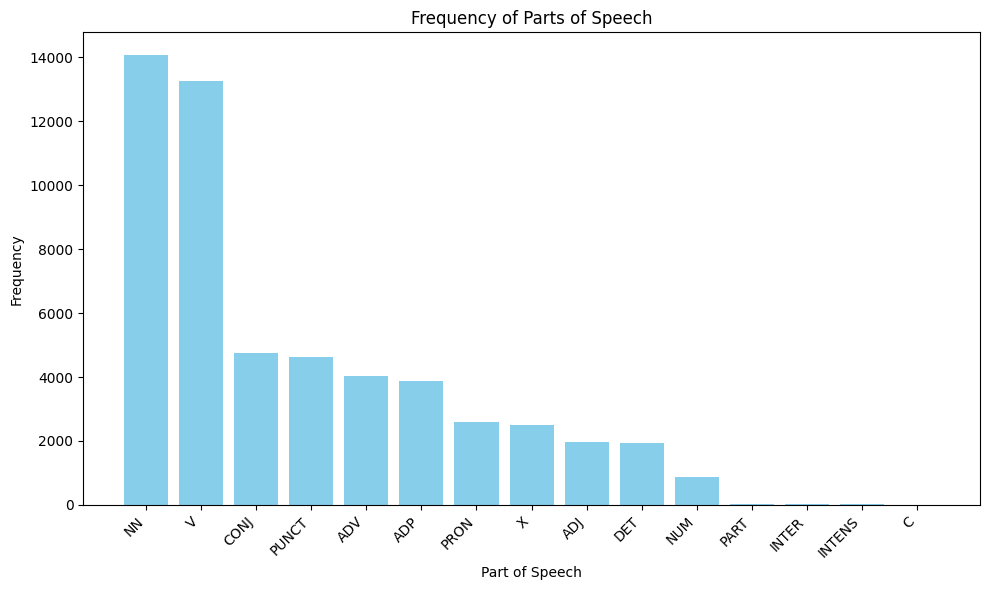

In [ ]:
# Data from the question
labels = ['NN', 'V', 'CONJ', 'PUNCT', 'ADV', 'ADP', 'PRON', 'X', 'ADJ', 'DET', 'NUM', 'PART', 'INTER', 'INTENS', 'C']
values = [14079, 13246, 4746, 4614, 4028, 3874, 2603, 2506, 1967, 1933, 860, 20, 17, 14, 4]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color='skyblue')
plt.xlabel('Part of Speech')
plt.ylabel('Frequency')
plt.title('Frequency of Parts of Speech')
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.tight_layout()

plt.show()

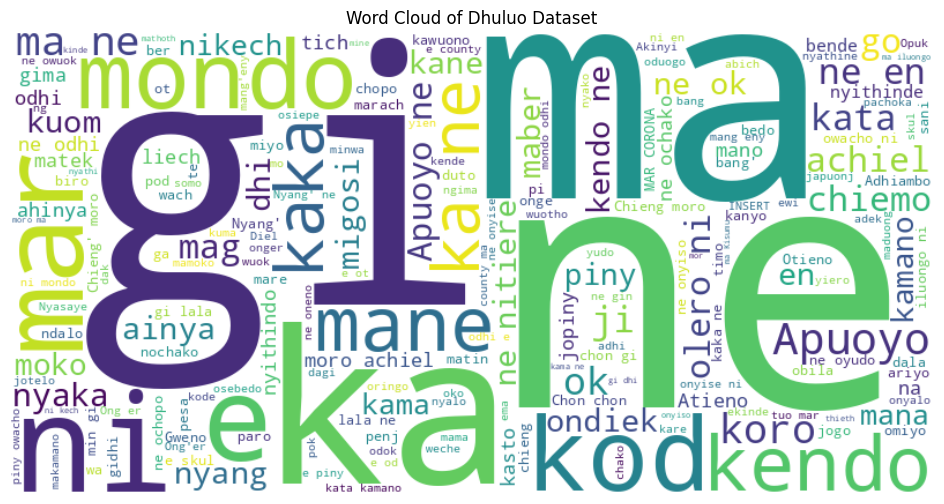

In [ ]:
# Concatenate all words into a single string
all_words = ' '.join(df['Word'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Plot the WordCloud image
plt.figure(figsize=(70, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Dhuluo Dataset')
plt.show()

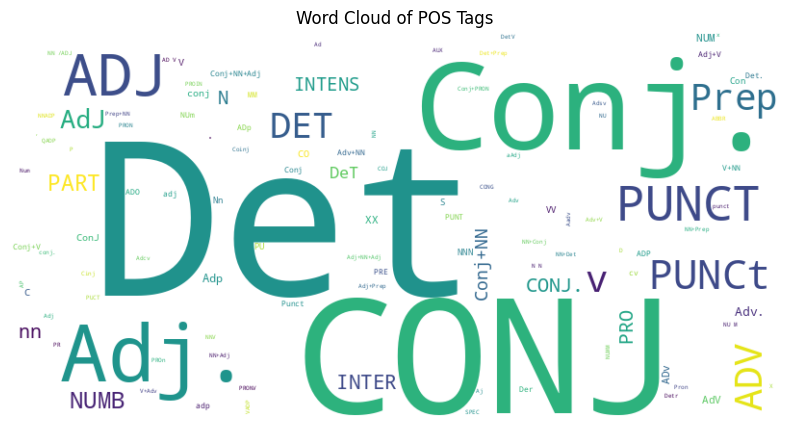

In [ ]:
# Sample data for the word cloud
tag_frequencies = {
    'NN': 14006, 'V': 13161, 'PUNCT': 4419, 'ADP': 3799, 'PRON': 2585,
    'Adv': 2530, 'X': 2484, 'Conj': 2115, 'ADV': 1415, 'Adj': 1400,
    'Det': 1390, 'CONJ': 1385, 'Conj.': 1208, 'NUM': 827, 'Det.': 472,
    'Adj.': 367, 'ADJ': 167, 'PUNCT': 110, 'PUNCt': 73, 'v': 61,
    'ADV': 60, 'Prep': 58, 'DET': 54, 'AdJ': 26, 'NUMB': 21,
    'PART': 20, 'INTER': 17, 'CONJ.': 16, 'x': 16, 'nn': 16,
    'PRO': 16, 'N': 14, 'INTENS': 14, 'Conj+NN': 13, 'DeT': 12,
    'V': 10, 'NN': 7, 'Adv.': 7, 'Adp': 6, 'ADv': 5, 'XX': 5,
    'AdV': 5, 'NUM': 5, 'ConJ': 4, 'CO': 4, 'C': 4, '.': 4,
    'NN': 4, 'V': 4, 'conj': 4, 'PU': 3, 'VV': 3, 'NNN': 3,
    'S': 3, 'ADP': 3, 'Nn': 3, 'Con': 3, 'Conj+V': 2, 'ADP': 2,
    'V+NN': 2, 'ADO': 2, 'PRE': 2, 'adp': 2, 'Der': 2, 'Adv+NN': 2,
    'MM': 2, 'Punct': 2, 'Conj': 2, 'Det.': 2, 'PUNT': 2, 'NUm': 2,
    'cv': 2, 'Conj+NN+Adj': 2, 'Adj+V': 2, 'ADp': 2, 'adj': 2,
    'Adj+NN+Adj': 1, 'x': 1, 'NNV': 1, 'Conj+PRON': 1, 'AD V': 1,
    'Detr': 1, 'NN /ADJ': 1, 'Adcv': 1, 'N N': 1, ',': 1, 'NU M': 1,
    'AP': 1, 'ABBR': 1, 'PRON': 1, 'NN': 1, 'Adv': 1, 'NUMM': 1,
    'DetV': 1, 'PRONV': 1, 'X': 1, 'Adj': 1, 'Num': 1, 'Det+Prep': 1,
    'V+Adv': 1, 'NN+Adj': 1, 'PROIN': 1, 'Aj': 1, 'PR': 1, 'aAdj': 1,
    'NU': 1, 'NN': 1, 'SPEC': 1, 'Ad': 1, 'Pron': 1, 'D': 1, 'PROn': 1,
    'NU': 1, 'PUCT': 1, 'Coinj': 1, 'Aadv': 1, 'Prep+NN': 1, 'Cinj': 1,
    'conj.': 1, 'punct': 1, 'Adv+V': 1, 'AUX': 1, 'Adj': 1, 'NNADP': 1,
    'Adj+Prep': 1, 'NN+Prep': 1, 'NN+Conj': 1, 'CONG': 1, 'QADP': 1,
    'VADP': 1, 'COJ': 1, 'P': 1, 'Adsv': 1, 'NN+Det': 1
}

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tag_frequencies)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of POS Tags')
plt.show()

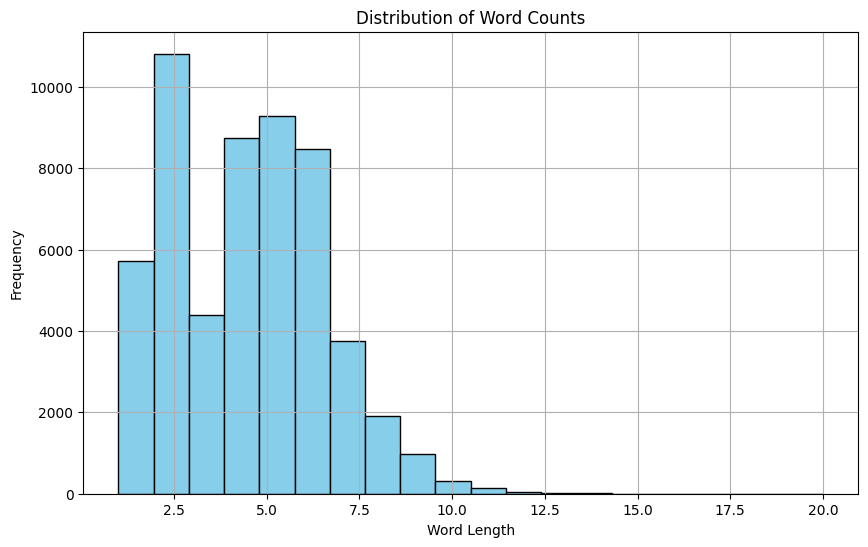

In [ ]:
# Calculate word counts
word_counts = df['Word'].apply(len)

# Plot histogram of word counts
plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts')
plt.grid(True)
plt.show()

#SPLITTING DATASETS INTO TESTING AND TRAINING SETS

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Word'], df['Mapped_Tag'], test_size=0.2, random_state=42)



#**Different algorithms**

**1. Random Forest**

In [ ]:
# Vectorize the words
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)




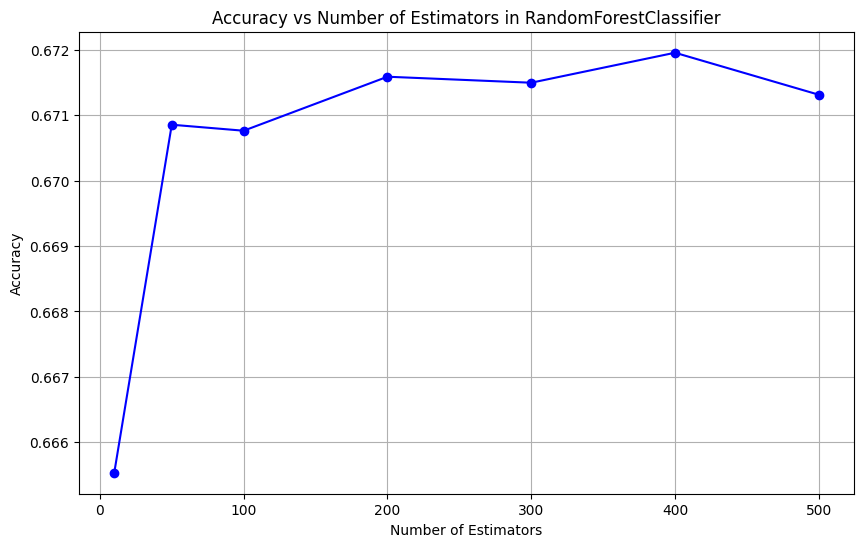

In [ ]:
# Train the model with RandomForestClassifier
# classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# classifier.fit(X_train_vectorized, y_train)

# # Predict the tags for the testing set
# predicted_tags = classifier.predict(X_test_vectorized)

# # Calculate accuracy
# accuracy = accuracy_score(y_test, predicted_tags)
# print("Accuracy:", accuracy)

n_estimators_list = [10, 50, 100, 200, 300, 400, 500]
accuracy_list = []

for n in n_estimators_list:
    classifier = RandomForestClassifier(n_estimators=n, random_state=42)
    classifier.fit(X_train_vectorized, y_train)
    predicted_tags = classifier.predict(X_test_vectorized)
    accuracy = accuracy_score(y_test, predicted_tags)
    accuracy_list.append(accuracy)

# Plotting the accuracy against the number of estimators
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, accuracy_list, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Estimators in RandomForestClassifier')
plt.grid(True)
plt.show()

In [ ]:
# Print the classification report
unique_labels = list(set(y_test))
report = classification_report(y_test, predicted_tags, labels=unique_labels, target_names=unique_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

         AUX       0.00      0.00      0.00         1
         ADJ       0.61      0.51      0.55       394
         NUM       0.88      0.66      0.75       170
        PRON       0.57      0.25      0.35       527
           C       0.00      0.00      0.00         1
          NN       0.90      0.82      0.86      2847
           X       0.83      0.44      0.58       494
         ADP       0.64      0.32      0.43       761
        CONJ       0.59      0.65      0.62       971
           V       0.91      0.67      0.77      2660
       INTER       0.50      0.50      0.50         2
         DET       0.36      0.67      0.47       360
          cv       1.00      1.00      1.00         1
         ADV       0.46      0.63      0.53       780
   Conj+PRON       0.00      0.00      0.00         1
      INTENS       0.00      0.00      0.00         3
       PUNCT       0.42      1.00      0.59       929
   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Save the model


In [ ]:
finalmodel = pk.dump(classifier,open('/content/drive/MyDrive/model.pkl','wb'))

In [ ]:
import graphviz
from sklearn.tree import export_graphviz
import pydotplus
# Visualize the first decision tree in the forest
estimator = classifier.estimators_[0]

# Export as dot file
dot_data = export_graphviz(estimator,
                           out_file=None,
                           feature_names=vectorizer.get_feature_names_out(),
                           class_names=classifier.classes_,
                           filled=True,
                           rounded=True,
                           special_characters=True)

# Convert to graphviz object
graph = pydotplus.graph_from_dot_data(dot_data)

# Show the graph
graphviz.Source(graph.to_string())

# Save the tree visualization to a file
graph.write_png("/content/drive/MyDrive/random_forest_tree.png")

True

Dispaly the plotted Tree


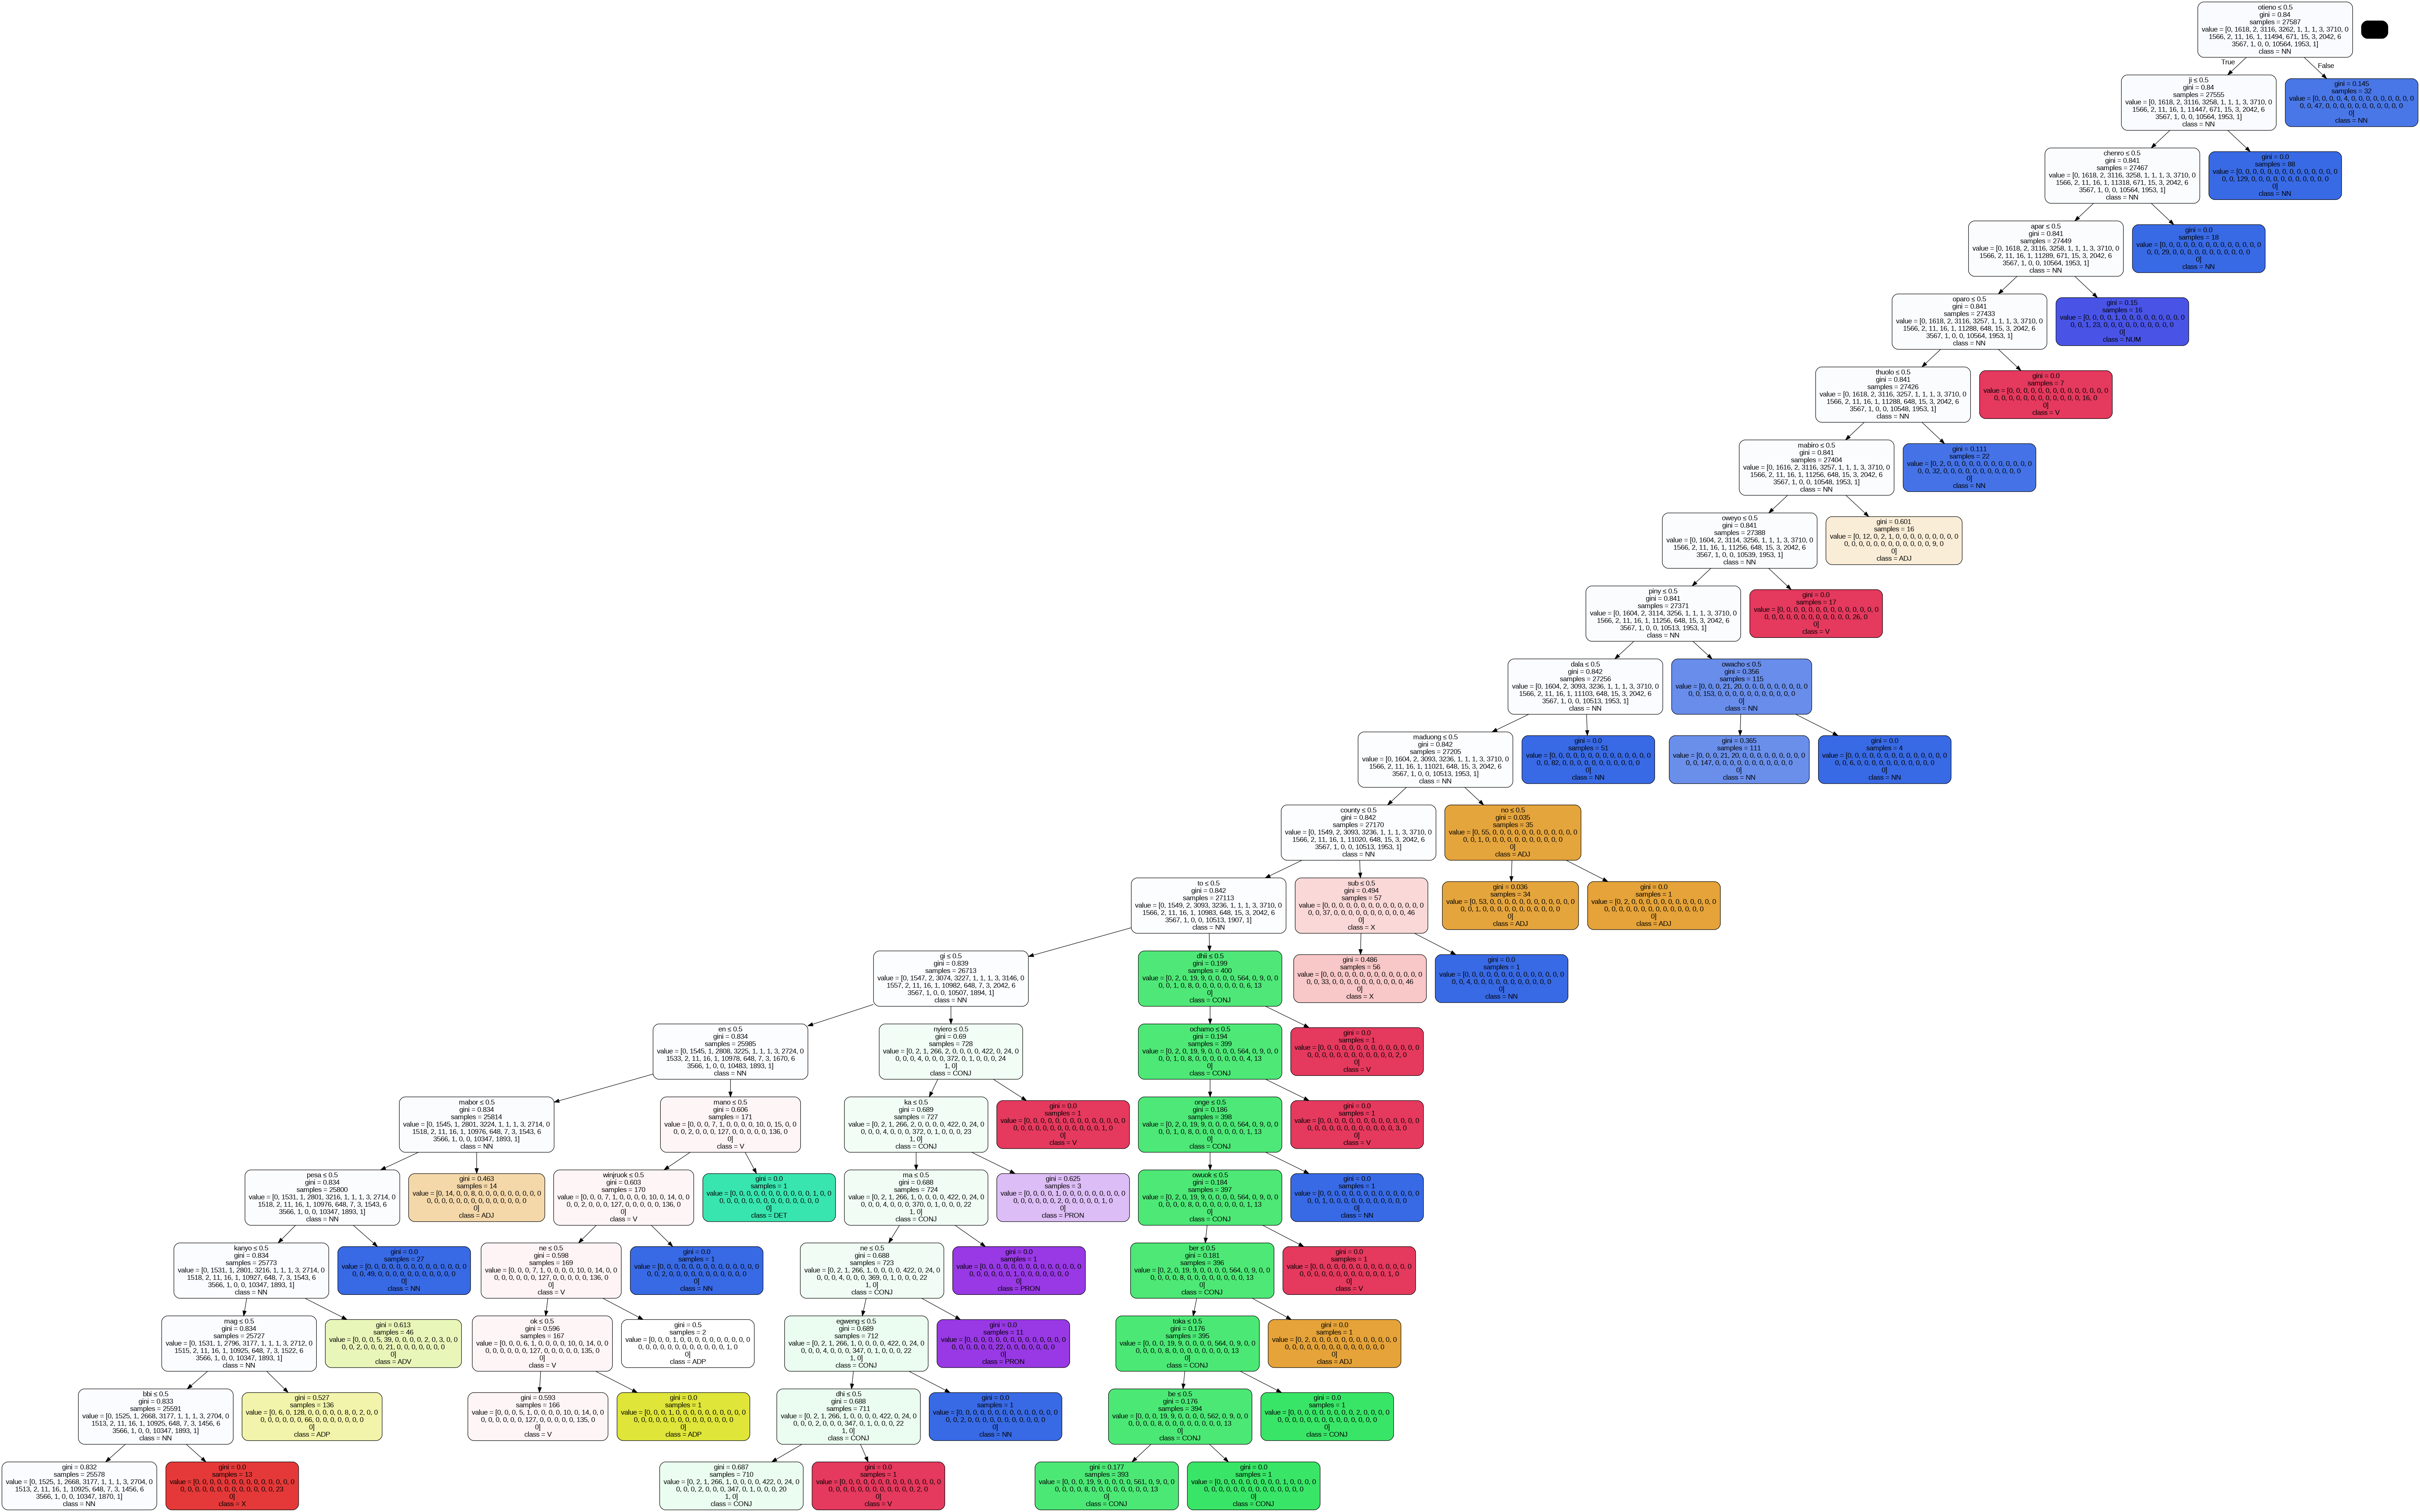

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/random_forest_tree.png',width=1000, height=1000)

In [ ]:

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, predicted_tags, average='weighted')
recall = recall_score(y_test, predicted_tags, average='weighted')
f1 = f1_score(y_test, predicted_tags, average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Precision: 0.7355096906754623
Recall: 0.6713120014669478
F1-Score: 0.676039124872783


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Ask user to input Dhuluo word

In [ ]:
loadingmodel = pk.load(open('/content/drive/MyDrive/model.pkl','rb'))

In [ ]:
# Function to predict POS tag for a word
def predict_pos_tag(word):
    word_vector = vectorizer.transform([word])
    predicted_tag = loadingmodel.predict(word_vector)[0]
    return predicted_tag

# Ask the user to input a word
user_word = input("Enter a word in Dhuluo: ")

# Predict the POS tag for the user input
predicted_tag = predict_pos_tag(user_word)
print(f"Predicted POS tag for '{user_word}': {predicted_tag}")

Enter a word in Dhuluo: ber
Predicted POS tag for 'ber': ADJ


**2. Support Vector Machine**

In [ ]:
# Vectorize the words
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

#Train the model

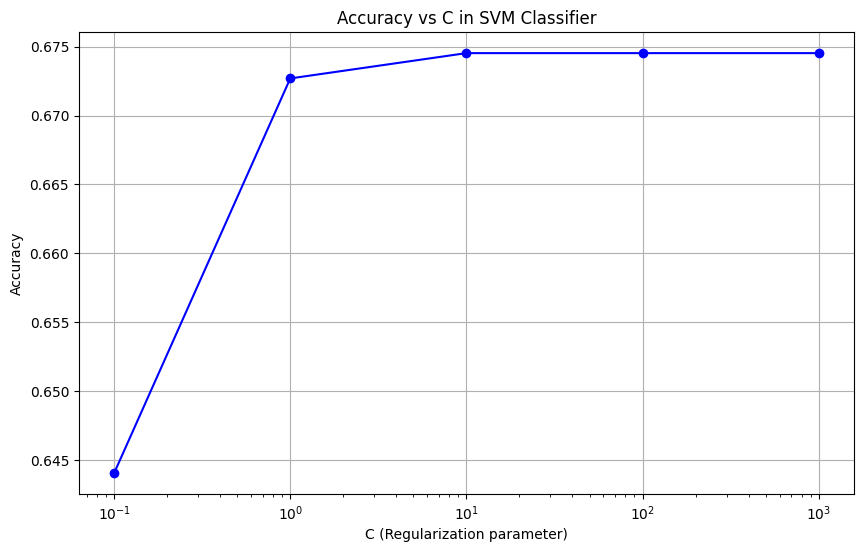

In [ ]:
# Train the model with Support Vector Machine (SVM)
# svcclassifier = SVC()
# svcclassifier.fit(X_train_vectorized, y_train)

# # Predict the tags for the testing set
# predicted_tags = svcclassifier.predict(X_test_vectorized)

# # Calculate accuracy
# accuracy = accuracy_score(y_test, predicted_tags)
# print("Accuracy:", accuracy)

C_values = [0.1, 1, 10, 100, 1000]
accuracy_list = []

for C in C_values:
    svcclassifier = SVC(C=C, random_state=42)
    svcclassifier.fit(X_train_vectorized, y_train)
    predicted_tags = svcclassifier.predict(X_test_vectorized)
    accuracy = accuracy_score(y_test, predicted_tags)
    accuracy_list.append(accuracy)

# Plotting the accuracy against the C values
plt.figure(figsize=(10, 6))
plt.plot(C_values, accuracy_list, marker='o', linestyle='-', color='b')
plt.xscale('log')
plt.xlabel('C (Regularization parameter)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C in SVM Classifier')
plt.grid(True)
plt.show()

In [ ]:
# Calculate precision, recall, and F1-score
precision = precision_score(y_test, predicted_tags, average='weighted')
recall = recall_score(y_test, predicted_tags, average='weighted')
f1 = f1_score(y_test, predicted_tags, average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Precision: 0.7327170232776848
Recall: 0.6726872650591363
F1-Score: 0.6754750508319276


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Print the classification report
unique_labels = list(set(y_test))
report = classification_report(y_test, predicted_tags, labels=unique_labels, target_names=unique_labels)
print("Classification Report:\n", report)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

       PUNCT       0.42      1.00      0.59       929
         ADP       0.67      0.32      0.43       761
          cv       0.00      0.00      0.00         1
   Conj+PRON       0.00      0.00      0.00         1
           C       0.00      0.00      0.00         1
         ADJ       0.62      0.50      0.55       394
           X       0.84      0.43      0.57       494
       INTER       0.00      0.00      0.00         2
        CONJ       0.59      0.65      0.62       971
        PRON       0.57      0.24      0.34       527
         NUM       0.89      0.62      0.73       170
         DET       0.37      0.66      0.47       360
        PART       0.00      0.00      0.00         5
         AUX       0.00      0.00      0.00         1
         ADV       0.46      0.63      0.53       780
          NN       0.90      0.83      0.86      2847
           V       0.89      0.68      0.77      2660
   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Save the model

In [ ]:
savemodel = pk.dump(svcclassifier,open('/content/drive/MyDrive/svm_model.pkl','wb'))

#Load model

In [ ]:
loadsvc = pk.load(open('/content/drive/MyDrive/svm_model.pkl','rb'))

**User Input Function**

In [ ]:
# Function to predict POS tag for a word
def predict_pos_tag(word):
    word_vector = vectorizer.transform([word])
    predicted_tag = loadsvc.predict(word_vector)[0]
    return predicted_tag

# Ask the user to input a word
user_word = input("Enter a word in Dhuluo: ")

# Predict the POS tag for the user input
predicted_tag = predict_pos_tag(user_word)
print(f"Predicted POS tag for '{user_word}': {predicted_tag}")

Enter a word in Dhuluo: ,
Predicted POS tag for ',': PUNCT


**3. RNN ALGORITHM**

In [ ]:
# Encode the tags
label_encoder = LabelEncoder()
df['Mapped_Tag'] = label_encoder.fit_transform(df['Mapped_Tag'])

# Tokenize the words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Word'])
X = tokenizer.texts_to_sequences(df['Word'])
X = pad_sequences(X, padding='post')

# Prepare target variable
y = to_categorical(df['Mapped_Tag'])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define the RNN model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=64, input_length=X.shape[1]))
model.add(SimpleRNN(64, return_sequences=False))
model.add(Dense(y.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

model.summary()


Epoch 1/20
1091/1091 [==============================] - 24s 19ms/step - loss: 1.1190 - accuracy: 0.6154 - val_loss: 0.8322 - val_accuracy: 0.6942
Epoch 2/20
1091/1091 [==============================] - 13s 12ms/step - loss: 0.6666 - accuracy: 0.7610 - val_loss: 0.8172 - val_accuracy: 0.6924
Epoch 3/20
1091/1091 [==============================] - 18s 16ms/step - loss: 0.5860 - accuracy: 0.7786 - val_loss: 0.8030 - val_accuracy: 0.7095
Epoch 4/20
1091/1091 [==============================] - 19s 17ms/step - loss: 0.5627 - accuracy: 0.7789 - val_loss: 0.8161 - val_accuracy: 0.7125
Epoch 5/20
1091/1091 [==============================] - 21s 19ms/step - loss: 0.5502 - accuracy: 0.7808 - val_loss: 0.8056 - val_accuracy: 0.7027
Epoch 6/20
1091/1091 [==============================] - 18s 16ms/step - loss: 0.5420 - accuracy: 0.7816 - val_loss: 0.8204 - val_accuracy: 0.6959
Epoch 7/20
1091/1091 [==============================] - 13s 12ms/step - loss: 0.5353 - accuracy: 0.7865 - val_loss: 0.8349 -

In [ ]:
# Predict the tags for the testing set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print("Accuracy:", accuracy)

341/341 [==============================] - 1s 3ms/step
Accuracy: 0.7069771706243697


In [ ]:
# Calculate precision, recall, and F1-score
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Precision: 0.7320243320410037
Recall: 0.7069771706243697
F1-Score: 0.7022191346880052


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Save the model

In [ ]:
rnn = pk.dump(model,open('/content/drive/MyDrive/rnn_model.pkl','wb'))

#Load the model

In [ ]:
rnnload = pk.load(open('/content/drive/MyDrive/rnn_model.pkl','rb'))

In [ ]:
# Function to predict POS tag for a word
def predict_pos_tag(word):
    word_seq = tokenizer.texts_to_sequences([word])
    word_seq_padded = pad_sequences(word_seq, maxlen=X.shape[1], padding='post')
    predicted_tag = rnnload.predict(word_seq_padded)
    predicted_tag_class = np.argmax(predicted_tag, axis=1)[0]
    return label_encoder.inverse_transform([predicted_tag_class])[0]

# Ask the user to input a word
user_word = input("Enter a word in Dhuluo: ")

# Predict the POS tag for the user input
predicted_tag = predict_pos_tag(user_word)
print(f"Predicted POS tag for '{user_word}': {predicted_tag}")

Enter a word in Dhuluo: ber
1/1 [==============================] - 1s 673ms/step
Predicted POS tag for 'ber': ADJ


#**LSTM ALGORITHM**

In [ ]:

# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_length=X.shape[1]))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(y.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Predict the tags for the testing set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print("Accuracy:", accuracy)


Epoch 1/5
1091/1091 [==============================] - 21s 14ms/step - loss: 1.3879 - accuracy: 0.5407 - val_loss: 0.9340 - val_accuracy: 0.6846
Epoch 2/5
1091/1091 [==============================] - 15s 13ms/step - loss: 0.7701 - accuracy: 0.7369 - val_loss: 0.8175 - val_accuracy: 0.7085
Epoch 3/5
1091/1091 [==============================] - 15s 13ms/step - loss: 0.6289 - accuracy: 0.7743 - val_loss: 0.8033 - val_accuracy: 0.7079
Epoch 4/5
1091/1091 [==============================] - 14s 13ms/step - loss: 0.5848 - accuracy: 0.7829 - val_loss: 0.8078 - val_accuracy: 0.7149
Epoch 5/5
341/341 [==============================] - 1s 2ms/step
Accuracy: 0.7111029614009352


In [ ]:
# Calculate precision, recall, and F1-score
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Precision: 0.7177877697583566
Recall: 0.7111029614009352
F1-Score: 0.7025997371453102


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Save LSTM model

In [ ]:
lstmload = pk.dump(model,open('/content/drive/MyDrive/lstm_model.pkl','wb'))

#Load the LSTM model

In [ ]:
loadlstm = pk.load(open('/content/drive/MyDrive/lstm_model.pkl','rb'))

In [ ]:
# Function to predict POS tag for a word
def predict_pos_tag(word):
    word_seq = tokenizer.texts_to_sequences([word])
    word_seq_padded = pad_sequences(word_seq, maxlen=X.shape[1], padding='post')
    predicted_tag = loadlstm.predict(word_seq_padded)
    predicted_tag_class = np.argmax(predicted_tag, axis=1)[0]
    return label_encoder.inverse_transform([predicted_tag_class])[0]

# Ask the user to input a word
user_word = input("Enter a word in Dhuluo: ")

# Predict the POS tag for the user input
predicted_tag = predict_pos_tag(user_word)
print(f"Predicted POS tag for '{user_word}': {predicted_tag}")

Enter a word in Dhuluo: ahinya
1/1 [==============================] - 0s 482ms/step
Predicted POS tag for 'ahinya': ADV


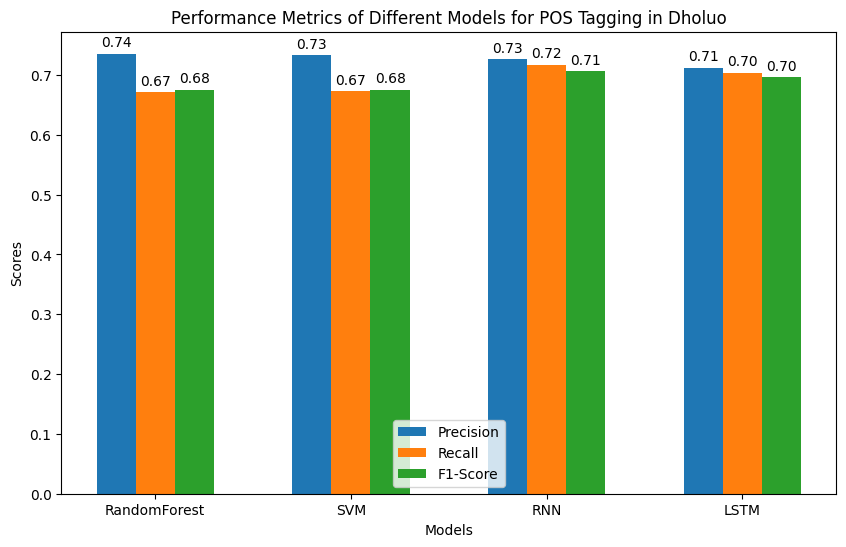

In [ ]:
# Data
models = ['RandomForest', 'SVM', 'RNN', 'LSTM']
precision = [0.7356, 0.7327, 0.7264, 0.7125]
recall = [0.6708, 0.6727, 0.7172, 0.7036]
f1_score = [0.6754, 0.6755, 0.7065, 0.6961]

x = np.arange(len(models))
width = 0.2

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1-Score')

# Labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics of Different Models for POS Tagging in Dholuo')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Adding values on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    # 3 points vertical offset
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.show()

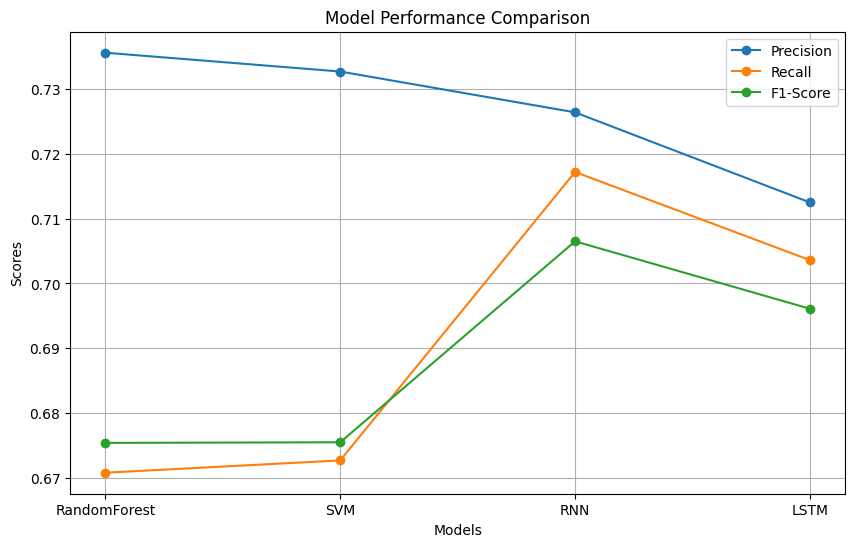

In [ ]:
models = ['RandomForest', 'SVM', 'RNN', 'LSTM']
precision = [0.7356, 0.7327, 0.7264, 0.7125]
recall = [0.6708, 0.6727, 0.7172, 0.7036]
f1_score = [0.6754, 0.6755, 0.7065, 0.6961]

# Plotting the line chart
plt.figure(figsize=(10, 6))

plt.plot(models, precision, marker='o', label='Precision')
plt.plot(models, recall, marker='o', label='Recall')
plt.plot(models, f1_score, marker='o', label='F1-Score')

plt.title('Model Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from google.colab import files
f = files.upload()

# Convert ipynb to html
import subprocess
file0 = list(f.keys())[0]
_ = subprocess.run(["pip", "install", "nbconvert"])
_ = subprocess.run(["jupyter", "nbconvert", file0, "--to", "html"])

# download the html
files.download(file0[:-5]+"html")

Saving POS_tagger (1).ipynb to POS_tagger (1).ipynb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>